In [1]:
import torch
import sys
sys.path.extend(['..'])
from mvn import MVNIso as MVN
from distributions import log_prob_banana as log_p
from samplers import stams_mvn_hmc
import matplotlib.pyplot as plt
from util import ess
from math import log, pi, sqrt
import time
from pathlib import Path
%matplotlib inline

For visualization purposes, make a discrete grid of x, y and compute the $p(x)$ density on it

In [2]:
x = torch.linspace(-4, 4, 201)
xx, yy = torch.meshgrid(x, x)
xy = torch.stack([xx.flatten(), yy.flatten()], dim=0)
log_p_grid = log_p(xy)
p_grid = (log_p_grid - torch.logsumexp(log_p_grid.flatten(), dim=0)).exp().reshape(xx.size())

Run HMC over $\theta$ for a variety of different $\lambda_{KL}$ values

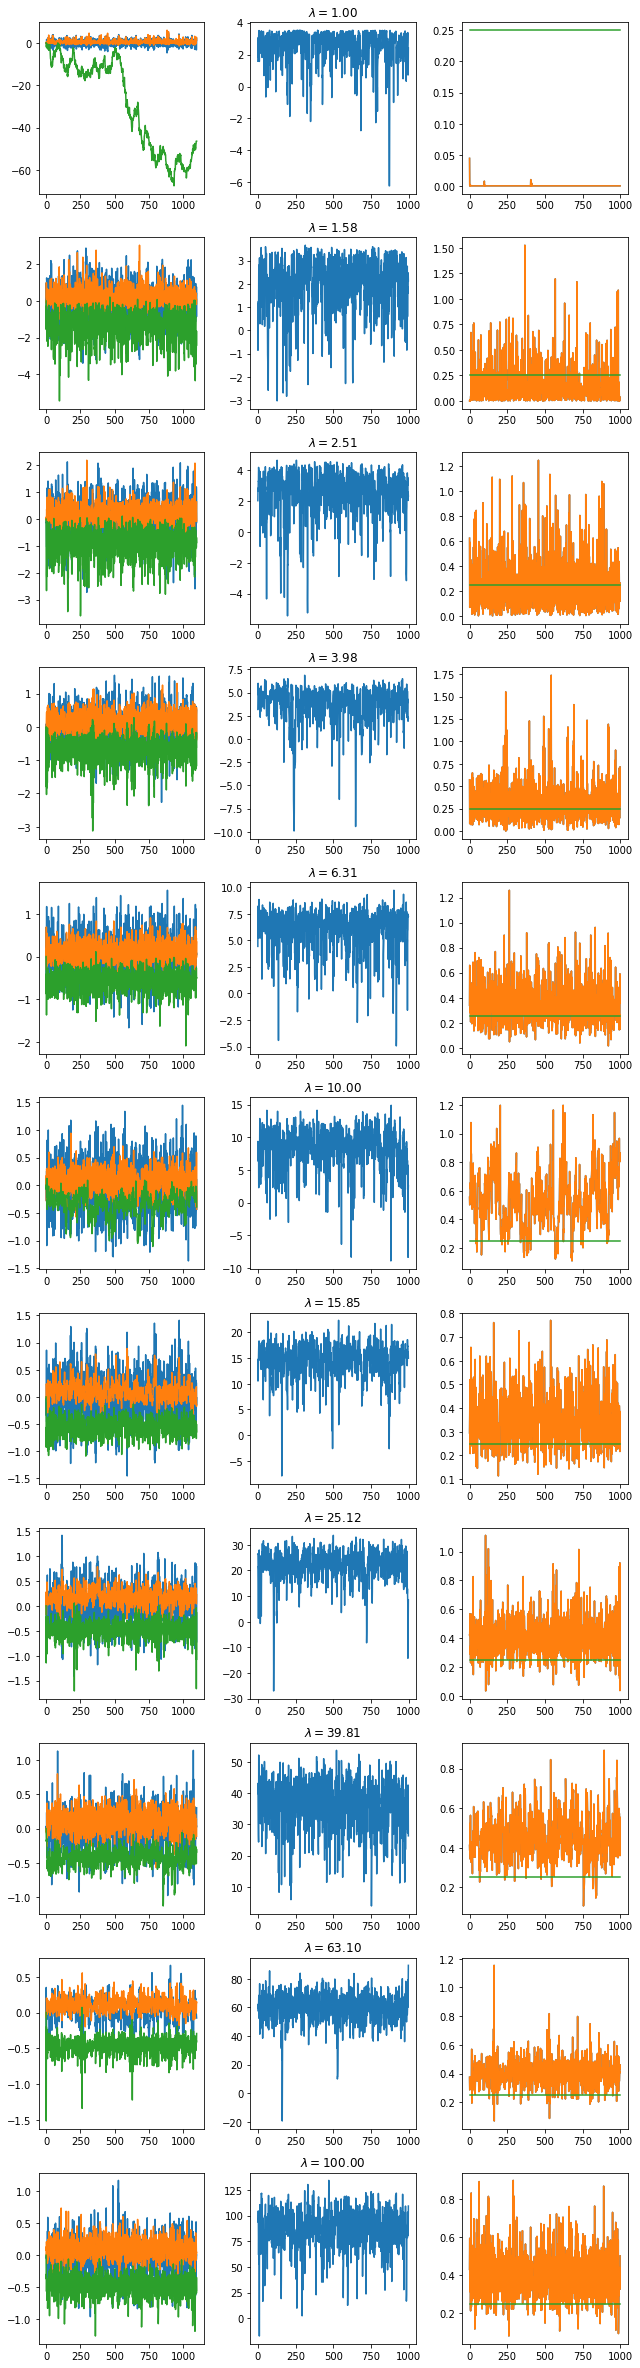

In [3]:
lambdas = torch.logspace(0, 2, 11)
results = []
qi = MVN(d=2)
fig, ax = plt.subplots(len(lambdas), 3, figsize=(9,3*len(lambdas)))
for i, l in enumerate(lambdas):
    save_file = Path('results') / f"mi_kl_hmc_lam={l.item():.3f}.dat"
    if save_file.exists():
        data = torch.load(save_file)
    else:
        data = {'results': stams_mvn_hmc(log_p, lam_kl=l, q_init=qi, n_samples=1000)}
        torch.save(data, save_file)
    results.append(data['results'])

    ax[i, 0].plot(torch.cat([data['results']['burn_samples'], data['results']['samples']], dim=0))
    ax[i, 1].plot(data['results']['log_psi'])
    ax[i, 1].set_title(f'$\lambda=${l:.2f}')
    ax[i, 2].plot(data['results']['masses'])
fig.tight_layout()

Inspect some metadata like acceptance ratio and effective sample size per $\lambda$

TODO - run a few chains and use rhat for convergence tests

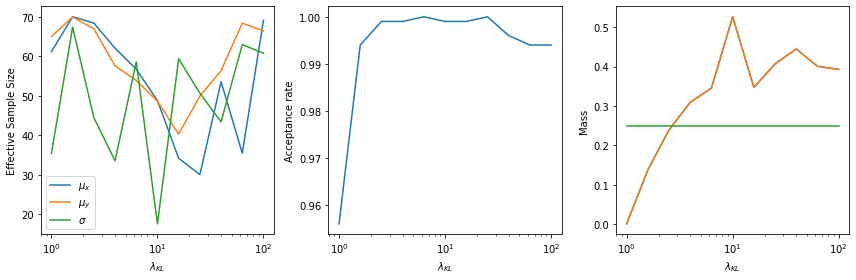

In [4]:
ess_values = torch.zeros(len(lambdas), results[0]['samples'].size(1))
mass_values = torch.zeros(len(lambdas), results[0]['samples'].size(1))
for i, (l, r) in enumerate(zip(lambdas, results)):
    s = r['samples']
    s[:,-1] = s[:,-1].exp()
    ess_values[i, :] = ess(s)
    mass_values[i, :] = r['masses'].mean(dim=0)

fig, ax = plt.subplots(1,3,figsize=(12,4))
ax[0].semilogx(lambdas, ess_values)
ax[0].set_xlabel(r'$\lambda_{KL}$')
ax[0].legend([r'$\mu_x$', r'$\mu_y$', r'$\sigma$'])
ax[0].set_ylabel('Effective Sample Size')

ax[1].semilogx(lambdas, [r['accept'] for r in results])
ax[1].set_xlabel(r'$\lambda_{KL}$')
ax[1].set_ylabel('Acceptance rate')

ax[2].semilogx(lambdas, mass_values)
ax[2].set_xlabel(r'$\lambda_{KL}$')
ax[2].set_ylabel('Mass')

fig.tight_layout()

Compute $E[KL]$ and Stams-approximation to $MI$ for each $\lambda$

In [5]:
def expected_kl(log_p, theta_samples, n_kl_samples=100):
    q = MVN(d=2)
    sum_kl = 0.
    for th in theta_samples:
        q.theta.copy_(th)
        sum_kl += (-q.entropy() - q.monte_carlo_ev(log_p, n_kl_samples))
    return sum_kl / theta_samples.size(0)

def _log_psi_helper(theta, lam_kl):
    q = MVN(theta=theta)
    _kl = -q.entropy() - q.monte_carlo_ev(log_p)
    return 0.5*q.log_det_fisher() - lam_kl*_kl

def stams_mi(lam_kl, theta_samples):
    q = MVN(d=2)
    sum_ent_diff = 0.
    for th in theta_samples:
        q.theta.copy_(th)
        sum_ent_diff += -_log_psi_helper(th, lam_kl) + 0.5*q.log_det_fisher() - 0.5*q.d*log(2*pi)
    return sum_ent_diff / theta_samples.size(0)


ekl_values = torch.zeros(lambdas.size())
mi_values = torch.zeros(lambdas.size())
for i, (l, r) in enumerate(zip(lambdas, results)):
    ekl_values[i] = expected_kl(log_p, r['samples']) 
    mi_values[i] = stams_mi(l, r['samples'])

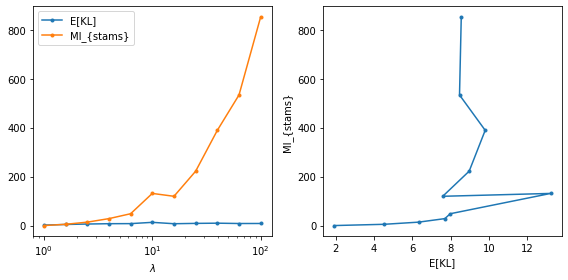

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].semilogx(lambdas, ekl_values, marker='.')
ax[0].semilogx(lambdas, mi_values, marker='.')
ax[0].set_xlabel('$\lambda$')
ax[0].legend(['E[KL]', 'MI_{stams}'])

ax[1].plot(ekl_values, mi_values, marker='.')
ax[1].set_xlabel('E[KL]')
ax[1].set_ylabel('MI_{stams}')

fig.tight_layout()